In [1]:
import pandas as pd
import gdown
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
# Cargar datos
url = 'https://drive.google.com/uc?id=1Eyei6msNpKNUA-pTcTIw_prHp-HAuESG'
output = 'TSLA.csv'
gdown.download(url, output, quiet=False)
tesla_data_df = pd.read_csv('TSLA.csv')



Downloading...
From: https://drive.google.com/uc?id=1Eyei6msNpKNUA-pTcTIw_prHp-HAuESG
To: /content/TSLA.csv
100%|██████████| 185k/185k [00:00<00:00, 3.71MB/s]


In [3]:
# Eliminar filas con valores nulos
tesla_data_df.dropna(inplace=True)


In [4]:
tesla_data_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,29-Jun-10,1.27,1.67,1.17,1.59,1.59,281494500.0
1,30-Jun-10,1.72,2.03,1.55,1.59,1.59,257806500.0
2,1-Jul-10,1.67,1.73,1.35,1.46,1.46,123282000.0
3,2-Jul-10,1.53,1.54,1.25,1.28,1.28,77097000.0
4,6-Jul-10,1.33,1.33,1.06,1.07,1.07,103003500.0
...,...,...,...,...,...,...,...
3729,23-Apr-25,254.86,259.45,244.43,250.74,250.74,150381900.0
3730,24-Apr-25,250.5,259.54,249.20,259.51,259.51,94464200.0
3731,25-Apr-25,261.69,286.85,259.63,284.95,284.95,167560700.0
3732,28-Apr-25,288.98,294.86,272.42,285.88,285.88,151731800.0


In [5]:
# Paso 2: Convertir 'Date' a datetime y establecer como índice
tesla_data_df['Date'] = pd.to_datetime(tesla_data_df['Date'], format='%d-%b-%y')
tesla_data_df.set_index('Date', inplace=True)

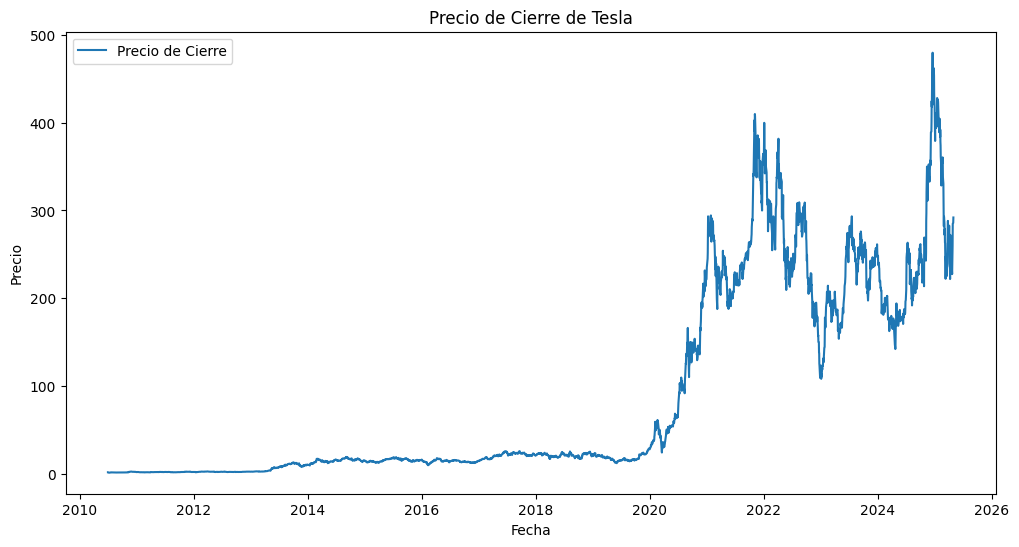

In [6]:
# Paso 3: Visualizar la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(tesla_data_df['Close'], label='Precio de Cierre')
plt.title('Precio de Cierre de Tesla')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.savefig('tesla_close_price.png')
plt.show()


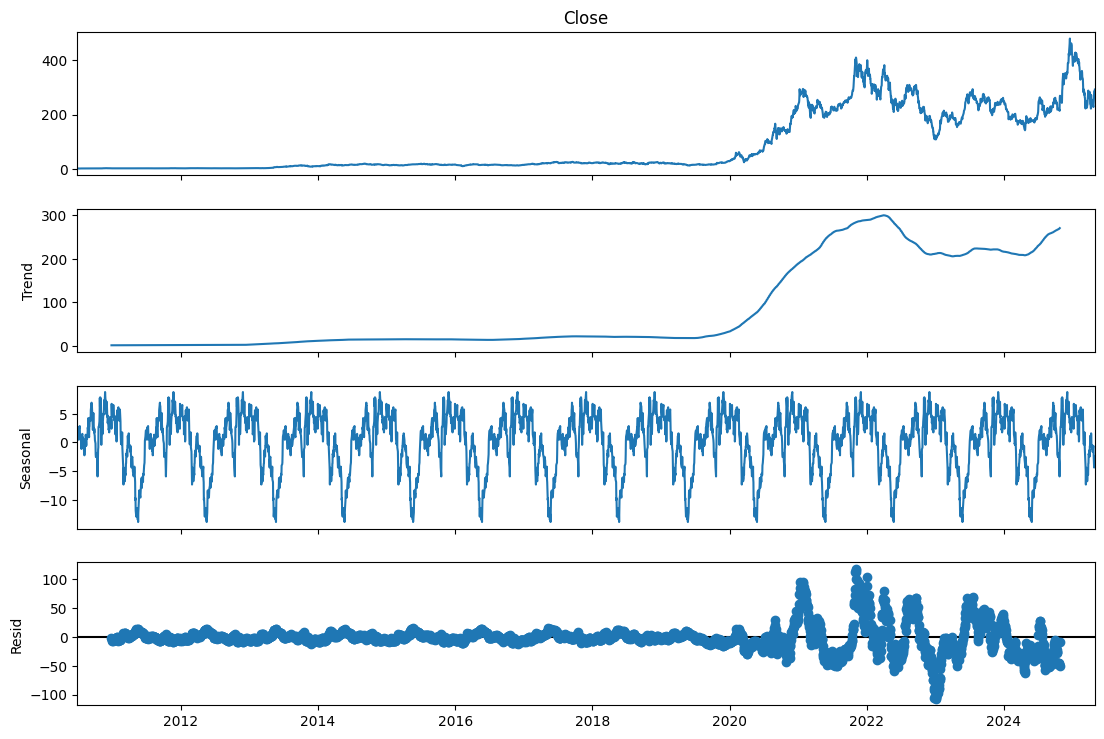

In [7]:
# Paso 4: Descomponer la serie para detectar estacionalidad
decomposition = seasonal_decompose(tesla_data_df['Close'], model='additive', period=252)  # 252 días hábiles por año
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.savefig('tesla_decomposition.png')
plt.show()

In [8]:
# Paso 5: Verificar estacionariedad con la prueba ADF
result = adfuller(tesla_data_df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print("La serie no es estacionaria. Aplicando diferenciación...")
    tesla_data_df['Close_diff'] = tesla_data_df['Close'].diff().dropna()
    result_diff = adfuller(tesla_data_df['Close_diff'].dropna())
    print('ADF Statistic (diff):', result_diff[0])
    print('p-value (diff):', result_diff[1])
else:
    print("La serie es estacionaria.")

ADF Statistic: -1.2983176938057932
p-value: 0.6299416189171649
La serie no es estacionaria. Aplicando diferenciación...
ADF Statistic (diff): -11.017047427281234
p-value (diff): 6.11941034487855e-20


In [9]:
# Paso 6: Ajustar modelo según análisis
# Si hay estacionalidad (observada en la descomposición), usamos SARIMA
# model = SARIMAX(tesla_data_df['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 252))
# model_fit = model.fit(disp=False)
# print(model_fit.summary())

# Si no hay estacionalidad usamos ARIMA para ello se requiere una derivación
# Diferenciar la serie una vez para hacerla estacionaria
tesla_data_df['Close_diff'] = tesla_data_df['Close'].diff().dropna()

# Ajustar el modelo ARIMA (p, d, q) a la serie original
# Usamos d=1 porque diferenciamos una vez; p=1 y q=1 como ejemplo inicial
model = ARIMA(tesla_data_df['Close'], order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
# Mostrar el resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3732
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11711.071
Date:                Wed, 21 May 2025   AIC                          23428.143
Time:                        01:30:00   BIC                          23446.816
Sample:                             0   HQIC                         23434.786
                               - 3732                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9819      0.014    -68.303      0.000      -1.010      -0.954
ma.L1          0.9863      0.012     79.829      0.000       0.962       1.010
sigma2        31.1816      0.246    126.685      0.0

In [11]:
# Función para filtrar el dataframe por fechas
def filter_by_date(df, start_date, end_date):
    return df.loc[start_date:end_date]

In [12]:
# Pronóstico ARIMA con intervalos de confianza
def arima_forecast_with_confidence(df, days):
    model = ARIMA(df['Close'], order=(1, 1, 1))
    model_fit = model.fit()
    forecast_result = model_fit.get_forecast(steps=days)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)
    return forecast, conf_int['lower Close'], conf_int['upper Close']

In [13]:
# Preparar datos para LSTM
def prepare_lstm_data(df, window=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    X, y = [], []
    for i in range(window, len(scaled_data)):
        X.append(scaled_data[i - window:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [14]:
# Pronóstico LSTM con intervalo de confianza aproximado
def lstm_forecast_with_confidence(df, days, window=60, n_simulations=10):
    X, y, scaler = prepare_lstm_data(df, window)
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]

    # Entrenar modelo LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(window, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Generar pronóstico base y simulaciones para intervalo de confianza
    last_sequence = scaler.transform(df['Close'][-window:].values.reshape(-1, 1))
    forecasts = []
    for _ in range(n_simulations):
        noisy_sequence = last_sequence + np.random.normal(0, 0.01, last_sequence.shape)
        noisy_sequence = noisy_sequence.reshape((1, window, 1))
        forecast = []
        current_sequence = noisy_sequence.copy()
        for _ in range(days):
            pred = model.predict(current_sequence, verbose=0)
            forecast.append(pred[0, 0])
            current_sequence = np.append(current_sequence[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
        forecasts.append(scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten())

    forecasts = np.array(forecasts)
    forecast_mean = np.mean(forecasts, axis=0)
    lower_bound = np.percentile(forecasts, 5, axis=0)
    upper_bound = np.percentile(forecasts, 95, axis=0)
    return forecast_mean, lower_bound, upper_bound


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

def plot_forecast_with_real_values(full_df, train_df, forecast_func, days, model_name):
    # Obtener la última fecha de entrenamiento
    last_train_date = train_df.index[-1]

    # Obtener las próximas 'days' fechas de trading después de la última fecha de entrenamiento
    forecast_dates = full_df.index[full_df.index > last_train_date][:days]

    # Verificar si hay suficientes fechas futuras disponibles
    if len(forecast_dates) < days:
        print(f"Advertencia: Solo hay {len(forecast_dates)} fechas futuras disponibles, pero se solicitaron {days} días.")
        days = len(forecast_dates)

    # Generar el pronóstico para estas fechas
    forecast, lower, upper = forecast_func(train_df, days)  # Asumiendo que forecast_func predice para estas fechas

    # Configurar la figura
    plt.figure(figsize=(12, 6))

    # Graficar los datos de entrenamiento
    plt.plot(train_df.index, train_df['Close'], label='Datos de Entrenamiento', color='blue')

    # Graficar el pronóstico con línea discontinua
    plt.plot(forecast_dates, forecast, label=f'Pronóstico {model_name}', color='red', linestyle='--')
    plt.fill_between(forecast_dates, lower, upper, color='gray', alpha=0.3, label='Intervalo de Confianza')

    # Extraer los valores reales para las fechas del pronóstico
    real_values = full_df.loc[forecast_dates]['Close']

    # Verificar si hay valores nulos en los datos reales
    if not real_values.isna().any():
        # Graficar valores reales con línea sólida
        plt.plot(forecast_dates, real_values, label='Valores Reales', color='green', linestyle='-')
        # Calcular y mostrar el error cuadrático medio (MSE)
        mse = mean_squared_error(real_values, forecast)
        plt.title(f'Pronóstico {model_name} ({forecast_dates[0].strftime("%Y-%m-%d")} a {forecast_dates[-1].strftime("%Y-%m-%d")}) - MSE: {mse:.2f}')
        print(f'MSE para {model_name}: {mse}')
    else:
        plt.title(f'Pronóstico {model_name} ({forecast_dates[0].strftime("%Y-%m-%d")} a {forecast_dates[-1].strftime("%Y-%m-%d")})')
        print("Advertencia: Los datos reales contienen valores nulos.")

    # Etiquetas y leyenda
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()
    plt.show()

In [16]:
# Función para comparar modelos
def plot_model_comparison(full_df, train_df, forecast_funcs, days, labels):
    forecast_dates = pd.date_range(start=train_df.index[-1], periods=days + 1, freq='D')[1:]
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['Close'], label='Datos de Entrenamiento', color='blue')

    mse_values = {}
    for forecast_func, label in zip(forecast_funcs, labels):
        forecast, lower, upper = forecast_func(train_df, days)
        plt.plot(forecast_dates, forecast, label=f'Pronóstico {label}')
        plt.fill_between(forecast_dates, lower, upper, alpha=0.3, label=f'Intervalo {label}')

        # Calcular MSE si hay valores reales
        if forecast_dates[-1] in full_df.index:
            real_values = full_df.loc[forecast_dates[0]:forecast_dates[-1]]['Close']
            if len(real_values) == days:
                mse = mean_squared_error(real_values, forecast)
                mse_values[label] = mse

    # Plotear valores reales si están disponibles
    if forecast_dates[-1] in full_df.index:
        real_values = full_df.loc[forecast_dates[0]:forecast_dates[-1]]['Close']
        if len(real_values) == days:
            plt.plot(forecast_dates, real_values, label='Valores Reales', color='green')
            title = 'Comparación de Pronósticos\n' + '\n'.join([f'MSE {label}: {mse:.2f}' for label, mse in mse_values.items()])
        else:
            title = 'Comparación de Pronósticos'
    else:
        title = 'Comparación de Pronósticos'

    plt.title(title)
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()
    plt.show()

In [17]:
# Ejemplo de uso
start_date = '2016-01-01'
end_date = '2018-01-01'
train_df = filter_by_date(tesla_data_df, start_date, end_date)

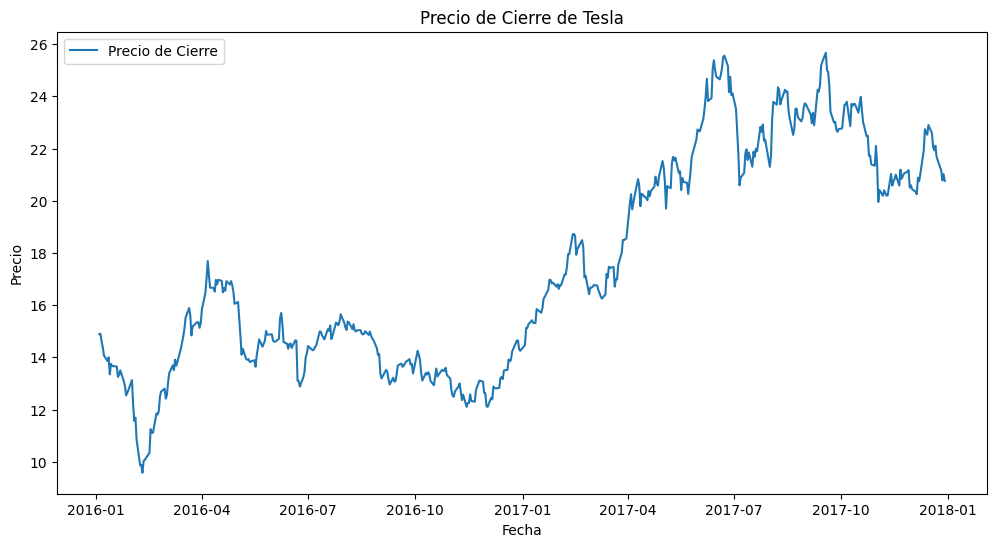

In [18]:
# Paso 3: Visualizar la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(train_df['Close'], label='Precio de Cierre')
plt.title('Precio de Cierre de Tesla')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.savefig('tesla_close_price.png')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

MSE para ARIMA: 7.424128084094391


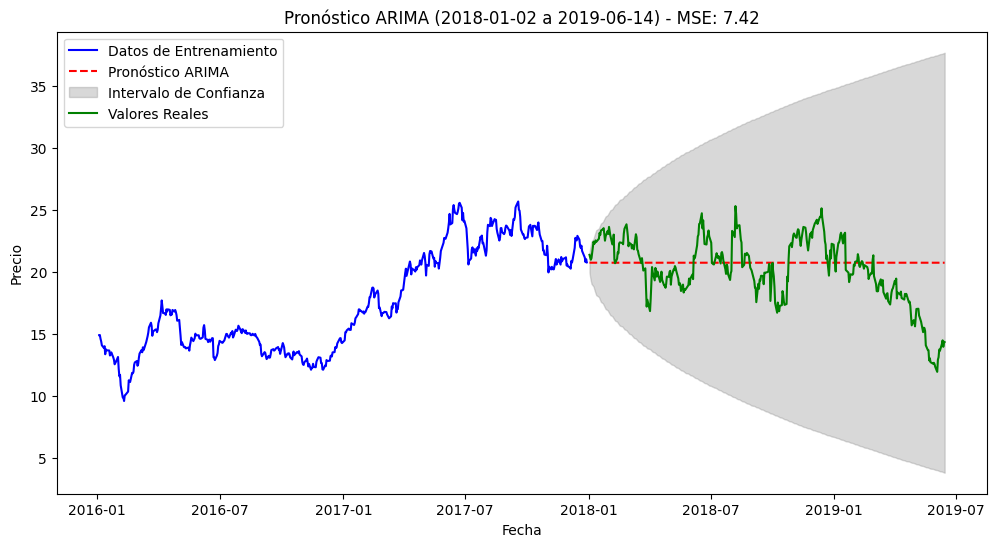

In [19]:
# Plotear ARIMA con cono de confianza y valores reales
plot_forecast_with_real_values(tesla_data_df, train_df, arima_forecast_with_confidence, 365, 'ARIMA')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE para LSTM: 124.26695547968669


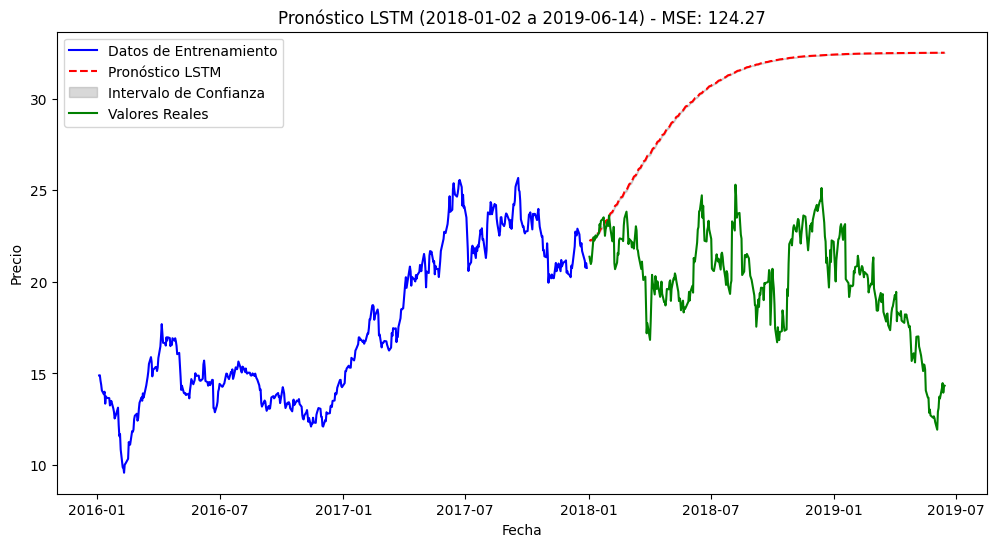

In [20]:
# Plotear LSTM con cono de confianza y valores reales
plot_forecast_with_real_values(tesla_data_df, train_df, lstm_forecast_with_confidence, 365, 'LSTM')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

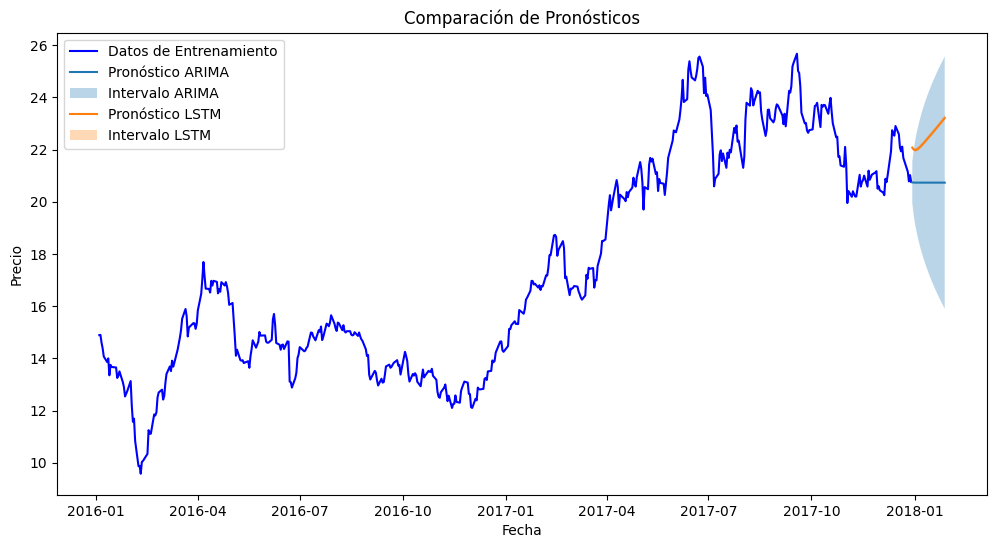

In [21]:
# Comparar ARIMA y LSTM
forecast_funcs = [arima_forecast_with_confidence, lstm_forecast_with_confidence]
labels = ['ARIMA', 'LSTM']
plot_model_comparison(tesla_data_df, train_df, forecast_funcs, 30, labels)